# Introduction

The goal of this project is to explore the question: "How does the amount of temperature change affect species abundance over time?"
By integrating biological survey data with historical climate records, the aim is to identify how temperature changes in a habitat influence ecological resilience. 

# Loading Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from scipy.spatial import cKDTree

data = pd.read_csv('/kaggle/input/global-species-abundance-and-diversity/BioTIMEQuery_24_06_2021.csv', low_memory=False)
metadata = pd.read_csv('/kaggle/input/global-species-abundance-and-diversity/BioTIMEMetadata_24_06_2021.csv', encoding='latin1', low_memory=False)
temp_data = pd.read_csv('/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv', low_memory=False)

# Cleaning & EDA

In [2]:
# quick view of datasets
data.info() 
metadata.info()
temp_data.info()

# using col "STUDY_ID" to merge sets, chosen columns of merged_data, preview
merged_data = pd.merge(data, metadata, on='STUDY_ID', how='left')
print(merged_data[['STUDY_ID', 'CLIMATE', 'REALM', 'HABITAT']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8552249 entries, 0 to 8552248
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   STUDY_ID                  int64  
 2   DAY                       float64
 3   MONTH                     float64
 4   YEAR                      int64  
 5   SAMPLE_DESC               object 
 6   PLOT                      object 
 7   ID_SPECIES                int64  
 8   LATITUDE                  float64
 9   LONGITUDE                 float64
 10  sum.allrawdata.ABUNDANCE  float64
 11  sum.allrawdata.BIOMASS    float64
 12  GENUS                     object 
 13  SPECIES                   object 
 14  GENUS_SPECIES             object 
dtypes: float64(6), int64(4), object(5)
memory usage: 978.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  --

In [3]:
# aggregating temp_data to match other sets (year, lat, long)
temp_data['dt'] = pd.to_datetime(temp_data['dt'])
temp_data['YEAR'] = temp_data['dt'].dt.year

# drop na for unique location, match dtypes
temp_coords = temp_data[['City', 'Latitude', 'Longitude']].dropna().drop_duplicates()

def convert_coord(x):
    if isinstance(x, str):
        val = float(x[:-1])
        return -val if x[-1] in ['S', 'W'] else val
    return x

temp_coords['lat_f'] = temp_coords['Latitude'].apply(convert_coord)
temp_coords['long_f'] = temp_coords['Longitude'].apply(convert_coord)

In [4]:
# building a spatial tree to connect coords from both datasets (nearest neighbor match), create result row in merged_data 
tree = cKDTree(temp_coords[['lat_f', 'long_f']])
distances, indicies = tree.query(merged_data[['LATITUDE', 'LONGITUDE']])
merged_data['Closest_City'] = temp_coords.iloc[indicies]['City'].values

In [5]:
# aggregating & merging for annual averages per city & year, creating final dataframe
city_annual_temp = temp_data.groupby(['City', 'YEAR'])['AverageTemperature'].mean().reset_index()
final_df = pd.merge(
    merged_data,
    city_annual_temp,
    left_on=['Closest_City', 'YEAR'],
    right_on=['City', 'YEAR'],
    how='inner'
) 

In [6]:
# calculating temperature anomaly to show deviation from average for a given location & general trend for additional context
city_baseline = final_df.groupby('Closest_City')['AverageTemperature'].transform('mean')
final_df['Temp_Anomaly'] = final_df['AverageTemperature']- city_baseline
final_df['City_Temp_Std'] = final_df.groupby('Closest_City')['AverageTemperature'].transform('std')

print(final_df[['YEAR', 'Closest_City', 'AverageTemperature', 'Temp_Anomaly']].head())

   YEAR Closest_City  AverageTemperature  Temp_Anomaly
0  1984  Minneapolis             5.95425     -0.015116
1  1984  Minneapolis             5.95425     -0.015116
2  1984  Minneapolis             5.95425     -0.015116
3  1984  Minneapolis             5.95425     -0.015116
4  1984  Minneapolis             5.95425     -0.015116


In [7]:
# checking that data wasn't lost during the cleaning & merging steps (nulls, realistic temps)
print(len(merged_data))
print(len(final_df))
print(len(final_df) / len(merged_data))


missing_temps = final_df['AverageTemperature'].isna().sum()
print(f"\nMissing temperature values: {missing_temps}")


print("\nTemperature Summary Statistics:")
print(final_df['AverageTemperature'].describe())

# results show: 98% data retained, 2% makes sense for nulls, etc, 0 missing temp values, temps mean 12.59, range -13.5 to 29.1

8552249
8457014
0.9888643326451323

Missing temperature values: 0

Temperature Summary Statistics:
count    8.457014e+06
mean     1.258939e+01
std      6.839957e+00
min     -1.350600e+01
25%      7.932500e+00
50%      1.176050e+01
75%      1.647667e+01
max      2.914300e+01
Name: AverageTemperature, dtype: float64


# Machine Learning Set Up

In [8]:
# narrowing focus onto Terrestrial realm only
terrestrial_df = final_df[final_df['REALM'] == 'Terrestrial'].copy()

print(f"Original Data Size: {len(final_df)}")
print(f"Terrestrial Data Size: {len(terrestrial_df)}")

# defining target variable (suitability), calculate mean temps for terrestrial areas
median_abund = terrestrial_df['sum.allrawdata.ABUNDANCE'].median()
terrestrial_df['SUITABILITY'] = (terrestrial_df['sum.allrawdata.ABUNDANCE'] > median_abund).astype(int)

# choosing relevant features
features = ['AverageTemperature', 'Temp_Anomaly', 'City_Temp_Std']

X = terrestrial_df[features]
y = terrestrial_df['SUITABILITY']

# split dataset into train & test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

print(f"Features used: {features}")
print(f"Training Set Shape: {X_train.shape}")

Original Data Size: 8457014
Terrestrial Data Size: 2878273
Features used: ['AverageTemperature', 'Temp_Anomaly', 'City_Temp_Std']
Training Set Shape: (2302618, 3)


In [9]:
# splitting set into test and training sets for XGBoost and RF, verify shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (2302618, 3)
Test set shape: (575655, 3)


# Model Training

In [10]:
# initializing models, fitting data to training sets
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Results

In [11]:
# Predictions and probability scores for ROC-AUC
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Classification reports to look at percision & recall
print("--- XGBoost Classification Report ---")
print(classification_report(y_test, xgb_preds))

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, rf_preds))

# Calculate ROC-AUC Scores
xgb_auc = roc_auc_score(y_test, xgb_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

print(f"\nXGBoost ROC-AUC: {xgb_auc:.4f}")
print(f"Random Forest ROC-AUC: {rf_auc:.4f}")

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.81      0.81    332278
           1       0.74      0.74      0.74    243377

    accuracy                           0.78    575655
   macro avg       0.78      0.78      0.78    575655
weighted avg       0.78      0.78      0.78    575655


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.82      0.81    332278
           1       0.75      0.74      0.74    243377

    accuracy                           0.78    575655
   macro avg       0.78      0.78      0.78    575655
weighted avg       0.78      0.78      0.78    575655


XGBoost ROC-AUC: 0.8625
Random Forest ROC-AUC: 0.8641


In [12]:
# Results
# ROC-AUC (0.8625 XGBoost v. 0.8641 Random Forest)
# Accuracy: 78%
# Recall & Precision 'unsuitable': 0.81
# Recall & Precision 'suitable': 0.75
# Both models perform about the same, and support temperature anomalies & stability are strong predictors of terrestrial species abundance



# Visualizations

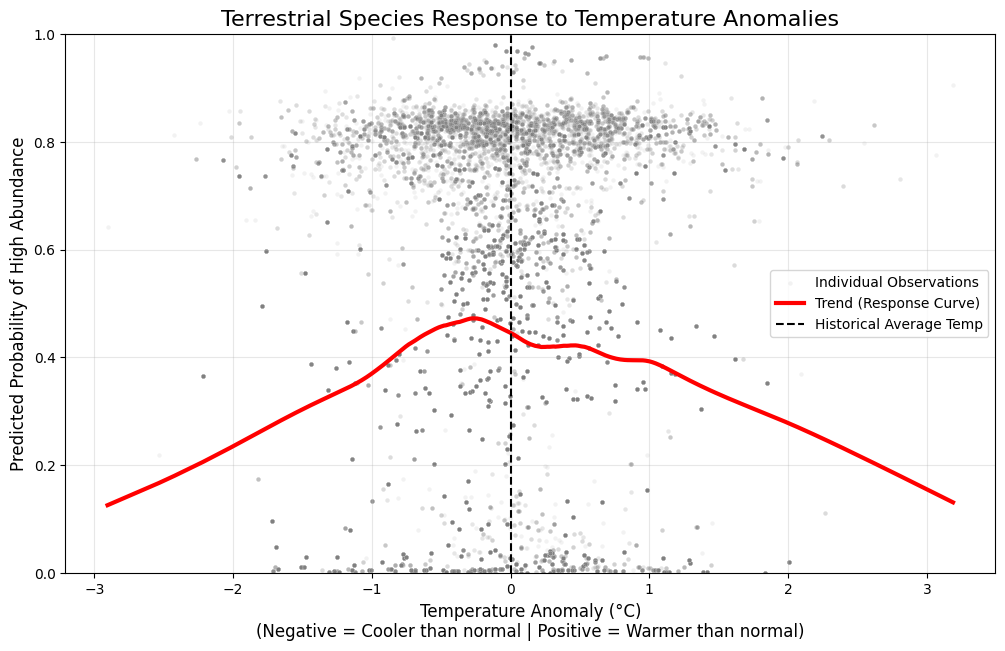

In [13]:
# Visualization to look at probability of high abundance vs temperature anomaly
# predictions, probability of suitability
probs = xgb_model.predict_proba(X_test)[:, 1]

plot_data = X_test.copy()
plot_data['Probability_of_Suitability'] = probs
sample_data = plot_data.sample(50000, random_state=42)  # sampling 50,000 for cleaner grahp
plt.figure(figsize=(12, 7))

# raw density scatterplot
sns.scatterplot(data=sample_data, x='Temp_Anomaly', y='Probability_of_Suitability',color='gray', alpha=0.1, s=10, label='Individual Observations')


# trend line for biological response
sns.regplot(data=sample_data, x='Temp_Anomaly', y='Probability_of_Suitability', scatter=False, lowess=True, line_kws={'color': 'red', 'linewidth': 3}, label='Trend (Response Curve)')

# formatting
plt.axvline(0, color='black', linestyle='--', label='Historical Average Temp')
plt.title('Terrestrial Species Response to Temperature Anomalies', fontsize=16)
plt.xlabel('Temperature Anomaly (°C)\n(Negative = Cooler than normal | Positive = Warmer than normal)', fontsize=12)
plt.ylabel('Predicted Probability of High Abundance', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.show()

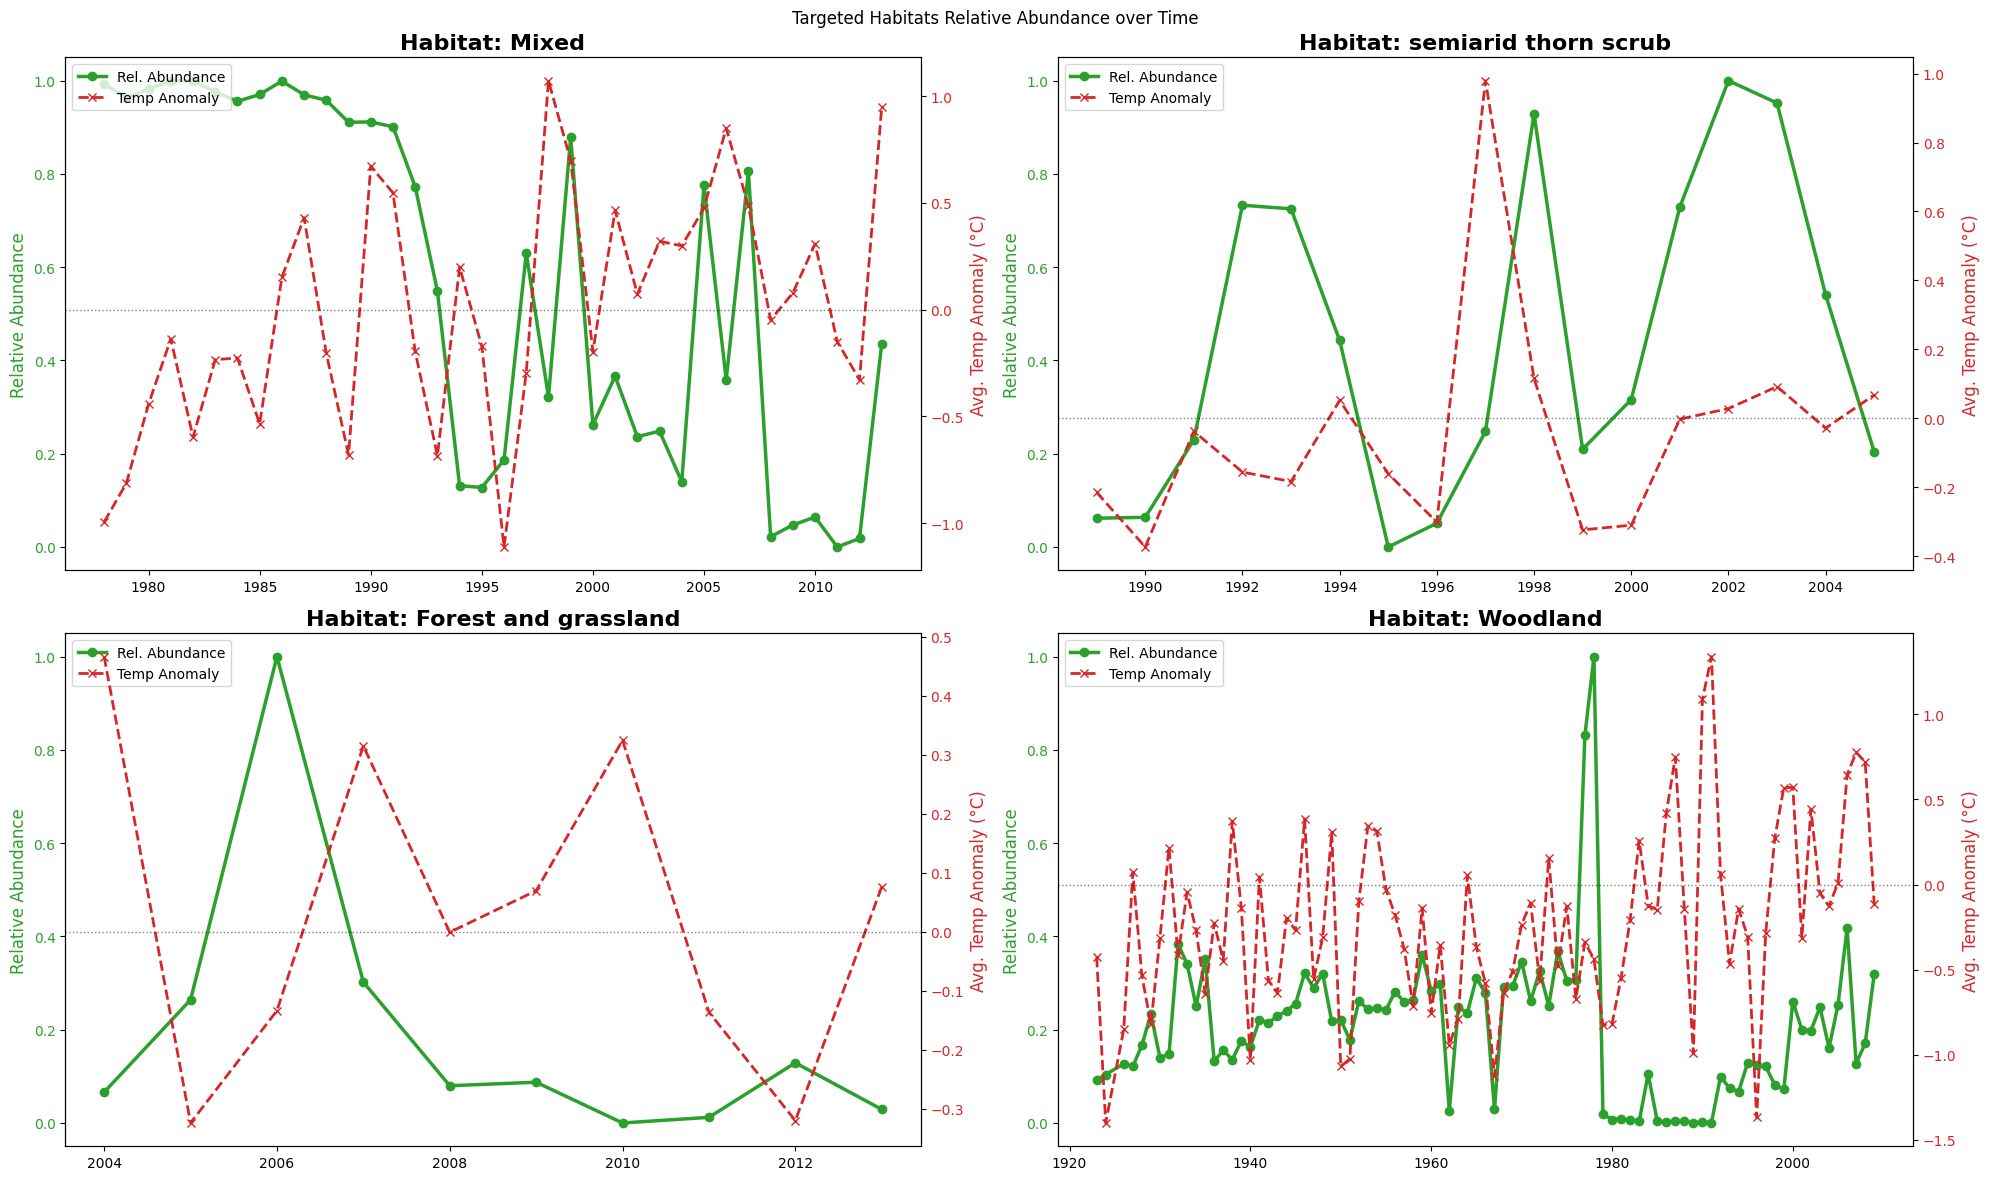

In [14]:
# visualization to show species abundance & temp anomaly over time

# filtering for terrestrial habitats with variation
terrestrial_only = final_df[final_df['REALM'] == 'Terrestrial'].copy()
habitat_variance = terrestrial_only.groupby('HABITAT')['sum.allrawdata.ABUNDANCE'].std().reset_index()
active_habitats_list = habitat_variance[habitat_variance['sum.allrawdata.ABUNDANCE'] > 0]['HABITAT'].tolist()

# selecting the top 4 habitats based on data volume
target_habitats = terrestrial_only[terrestrial_only['HABITAT'].isin(active_habitats_list)]['HABITAT'].value_counts().nlargest(4).index.tolist()

# aggregation and min-max scaling
habitat_trends = terrestrial_only[terrestrial_only['HABITAT'].isin(target_habitats)].groupby(['HABITAT', 'YEAR'])[['sum.allrawdata.ABUNDANCE', 'Temp_Anomaly']].mean().reset_index()
habitat_trends['Rel_Abundance'] = habitat_trends.groupby('HABITAT')['sum.allrawdata.ABUNDANCE'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

# plotting grid
n_cols = 2
n_rows = math.ceil(len(target_habitats) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
axes = axes.flatten()

for i, habitat in enumerate(target_habitats):
    ax1 = axes[i]
    subset = habitat_trends[habitat_trends['HABITAT'] == habitat].sort_values('YEAR')
    
    color_abund = 'tab:green'
    line1 = ax1.plot(subset['YEAR'], subset['Rel_Abundance'], 
                     color=color_abund, linewidth=2.5, marker='o', label='Rel. Abundance')
    
    ax1.set_ylabel('Relative Abundance', color=color_abund, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color_abund)
    ax1.set_title(f'Habitat: {habitat}', fontsize=16, fontweight='bold')
    
    ax2 = ax1.twinx()
    color_temp = 'tab:red'
    line2 = ax2.plot(subset['YEAR'], subset['Temp_Anomaly'], 
                     color=color_temp, linewidth=2, linestyle='--', marker='x', label='Temp Anomaly')
    
    ax2.set_ylabel('Avg. Temp Anomaly (°C)', color=color_temp, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_temp)
    ax2.axhline(0, color='black', linewidth=1, linestyle=':', alpha=0.5)

    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left')

plt.suptitle("Targeted Habitats Relative Abundance over Time")
plt.tight_layout()
plt.show()

# Conclusions

The biological response to temperature anomalies is neither symmetrical nor linear. There was a greater loss of abundance at warmer temperatures than at cooler temperatures. Even with a 1°C change, there is a significant drop in abundance. Further analysis could pinpoint a critical threshold for ecological resilience. There is variation in how different habitats respond to changes in temperature anomalies. The habitats categorized as mixed or woodland experienced greater amounts of fluctuation. The general pattern is still followed by the 4 habitats analyzed: rising temperatures correlate with a fall in relative abundance of the species. The predictive capability of the model showed that temperature anomalies and historical temperature stability are very effective features for predicting whether a habitat will remain suitable for high species abundance. 
